# Data Analysis Interview Challenge: Relax, Inc

Bradley Mensah


Springboard Data Science Track, Nov 2020 Cohort

## Data Dictionaries

**takehome_users.csv**

* **name**: the user's name
* **object_id**: the user's id
* **email**: email address
* **creation_source**: how their account was created. This takes on one of 5 values:
    * **PERSONAL_PROJECTS**: invited to join another user's personal workspace
    * **GUEST_INVITE**: invited to an organization as a guest (limited permissions)
    * **ORG_INVITE**: invited to an organization (as a full member)
    * **SIGNUP**: signed up via the website
    * **SIGNUP_GOOGLE_AUTH**: signed up using Google Authentication (using a Google email account for their login id)
* **creation_time**: when they created their account
* **last_session_creation_time**: unix timestamp of last login
* **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
* **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
* **org_id**: the organization (group of users) they belong to
* **invited_by_user_id**: which user invited them to join (if applicable).

**takehome_user_engagement.csv**

A usage summary table that has a row for each day that a user logged into the product.

## Task

**Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.**

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, plot_roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

### Data Wrangling

In [214]:
eng_df = pd.read_csv("takehome_user_engagement.csv")
eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [215]:
eng_df.shape

(207917, 3)

In [216]:
# check for missing values 
eng_df.isna().any()

time_stamp    False
user_id       False
visited       False
dtype: bool

In [217]:
# check dtypes
eng_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [218]:
# convert time_stamp to datetime
eng_df["time_stamp"] = pd.to_datetime(eng_df["time_stamp"], format="%Y-%m-%d %H:%M:%S")

# get day from time_stamp
eng_df["day"] = pd.to_datetime(eng_df["time_stamp"].dt.date, format="%Y-%m-%d")

In [219]:
# pivot_table with day as index, user_id as column, and visited as values
eng_df = eng_df.reset_index().pivot_table(index="day", columns="user_id", values="visited")

In [220]:
# resample to see visits per 7 day period 
eng_df.fillna(0, inplace=True)
eng_df = eng_df.resample("7D").sum()

In [221]:
# find adopted users 
adopted_users = []
for user in eng_df.columns:
    if (eng_df[user]>3.0).any():
        adopted_users.append(user)

In [222]:
print("{} users have used the service more than 3 times in a 7 day period.".format(len(adopted_users)))

1173 users have used the service more than 3 times in a 7 day period.


In [223]:
# import user data
users_df = pd.read_csv("takehome_users.csv")

In [224]:
# mark adopted users in users_df
users_df["adopted_user"] = users_df["object_id"].isin(adopted_users)
users_df.shape

(12000, 11)

In [225]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [226]:
users_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted_user                     bool
dtype: object

In [227]:
# check for missing values
users_df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
adopted_user                     0
dtype: int64

In [228]:
# drop "invited_by_user_id" since it is not a factor for predictions
users_df.drop("invited_by_user_id", axis=1, inplace=True)

It is possible that the NaN values for **last_session_creation_time** are users who created an account, but never used the service. I will check this by getting the **object_id** of users for whom **last_session_creation_time** is NaN, and finding if they have any engagement logged. 

In [229]:
no_eng = users_df.loc[users_df["last_session_creation_time"].isna(), "object_id"]

In [230]:
no_eng.isin(eng_df.columns).any()

False

None of the users for whom **last_session_creation_time** is NaN have any logged activity. Therefore, we will set the NaN values to 0.

In [231]:
users_df.fillna(0, inplace=True)

### EDA

We will do some preliminary EDA to form a hypothesis for which features are most important for predicting whether or not a user is an adopted user.

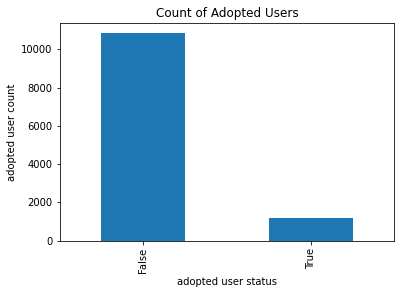

In [232]:
users_df.adopted_user.value_counts().plot(kind="bar", xlabel="adopted user status", ylabel="adopted user count", 
                                          title="Count of Adopted Users");

* this class imbalance may need to be addressed in the prediction stage

In [233]:
users_df.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

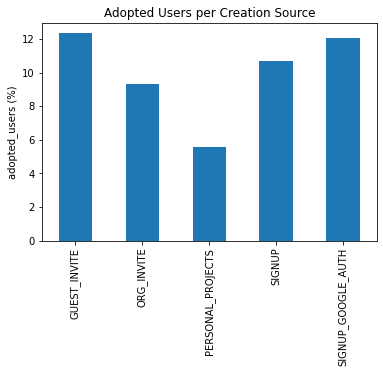

In [234]:
# bar chart of adopted users per creation source
pct_adoption = (users_df.groupby("creation_source").adopted_user.sum() / users_df.creation_source.value_counts())*100
pct_adoption.plot(kind="bar", ylabel="adopted_users (%)", title="Adopted Users per Creation Source");

* ORG_INVITE and SIGNUP_GOOGLE_AUTH are the creation sources with the highest adopted users with about 12% of users adopting for each source. It may end up being one of the more important features.
* Users who used the service for PERSONAL_PROJECTS were least likely to adopt. This could also end up being an important feature. 

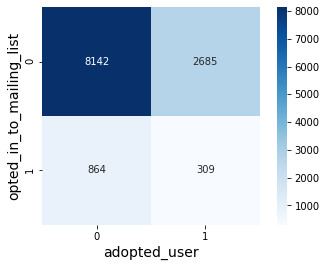

In [235]:
cm = confusion_matrix(users_df["adopted_user"], users_df["opted_in_to_mailing_list"])
sns.heatmap(cm, annot=True, fmt='.6g', cmap='Blues', square=True)
plt.xlabel("adopted_user", fontsize=14)
plt.ylabel("opted_in_to_mailing_list", fontsize=14)
plt.show();

* Whether or not a user opted in to the mailing list will likely have a significant impact on predictions as well, with most users who did not opt in also not adopting (top left, 8,142 users). However, there is a significant number of users who did adopt but did not opt in to the mailing list (top right, 2,865 users).

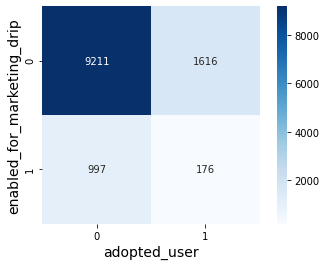

In [236]:
cm = confusion_matrix(users_df["adopted_user"], users_df["enabled_for_marketing_drip"])
sns.heatmap(cm, annot=True, fmt='.6g', cmap='Blues', square=True)
plt.xlabel("adopted_user", fontsize=14)
plt.ylabel("enabled_for_marketing_drip", fontsize=14)
plt.show();

* Very similar results to the previous visualization. We se that users who did not adopt the service also did not receieve the regular marketing drip. 

### Preprocessing

Now, we will find which features are most important for prediction. We will do the following preprocessing:
1. drop all columns that are not useful for predicting. This includes:
    * object_id
    * creation_time
    * name
    * email
    * last_session_creation_time
    * org_id
2. encode **creation_source** using one-hot encoding

In [237]:
# drop un-useful columns
users_df.drop(["object_id", 
               "creation_time", 
               "name", 
               "email", 
               "last_session_creation_time", 
               "org_id"], 
              axis=1, inplace=True)

In [238]:
# encode creation_source
onehot = OneHotEncoder()
column_names = users_df.drop("creation_source", axis=1).columns.to_list()
encoded = pd.DataFrame(onehot.fit_transform(np.array(users_df["creation_source"]).reshape(-1,1)).toarray())
encoded_df = pd.concat([users_df.drop("creation_source", axis=1), encoded], axis=1)
column_names.extend(list(onehot.get_feature_names()))
encoded_df.columns = column_names
encoded_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,x0_GUEST_INVITE,x0_ORG_INVITE,x0_PERSONAL_PROJECTS,x0_SIGNUP,x0_SIGNUP_GOOGLE_AUTH
0,1,0,False,1.0,0.0,0.0,0.0,0.0
1,0,0,False,0.0,1.0,0.0,0.0,0.0
2,0,0,False,0.0,1.0,0.0,0.0,0.0
3,0,0,False,1.0,0.0,0.0,0.0,0.0
4,0,0,False,1.0,0.0,0.0,0.0,0.0


### Model Selection

In [239]:
# split data into training and test sets
X = encoded_df.drop("adopted_user", axis=1)
y = encoded_df.adopted_user.copy().astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

First, we will use a dummy classifier to get benchmarks against which to compare our classifier:

In [250]:
dummy_cls = DummyClassifier(strategy="most_frequent")
dummy_cls.fit(X_train, y_train)
dummy_pred = dummy_cls.predict(X_test)
accuracy_score(y_test, dummy_pred)

0.9027777777777778

A dummy classifier that only chooses the most frequent class has an accuracy of 90%. Because of the large class imbalance, accuracy is not a good metric to judge my results by. 

Instead, I will use AUC-ROC. AUC-ROC will show the relationship between the true positive rate (users who adopt correctly identified) and the false positive rate (users who do not adopt incorrectly identified as adopt). As our goal is to identify which factors lead to user adoption, this is the most important distinction for our model to make. 

0.5


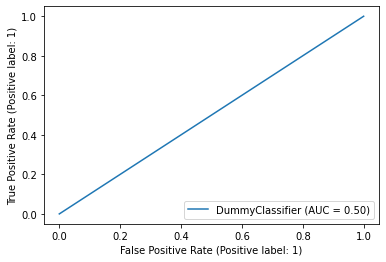

In [241]:
print(roc_auc_score(y_test, dummy_pred))
plot_roc_curve(dummy_cls, X_test, y_test);

In [242]:
# fit and predict an XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBClassifier
gb_cls = GBClassifier()
gb_cls.fit(X_train, y_train)
y_pred = gb_cls.predict(X_test)
roc_auc_score(y_test, y_pred)

0.5

In [243]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
roc_auc_score(y_test, rf_pred)

0.5

In [244]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
lr_pred = logreg.predict(X_test)
roc_auc_score(y_test, lr_pred)

0.5

In [248]:
from sklearn.cluster import KMeans
km = KMeans()
km.fit(X_train, y_train)
km_pred = km.predict(X_test)
roc_auc_score(y_test, km_pred)

0.49992219780219777

All of the models have the same ROC-AUC score out-the-box. I will move with the GradientBoostingClassifier as it generally outperforms other models. 

### Hyperparameter Tuning

In [209]:
# use GridSearchCV to tune hyperparameters for a Gradient Boosting classifier
param_dict = { 
    "learning_rate":[0.000001,0.00001,0.0001], 
    "subsample":[0.01, 0.1,1],
    "max_depth":[9,10,11],
    "min_samples_split":[0.01,0.1,1],
    "min_samples_leaf":[0.001,0.01,0.1],
    "n_estimators":[5,10,50,100],
    
}
gs = GridSearchCV(GBClassifier(), param_dict, scoring="roc_auc", cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
gs_pred = gs.predict(X_test)
roc_auc_score(y_test, gs_pred)

0.5

In [210]:
gs.best_params_

{'learning_rate': 1e-05,
 'max_depth': 10,
 'min_samples_leaf': 0.01,
 'min_samples_split': 0.01,
 'n_estimators': 5,
 'subsample': 0.1}

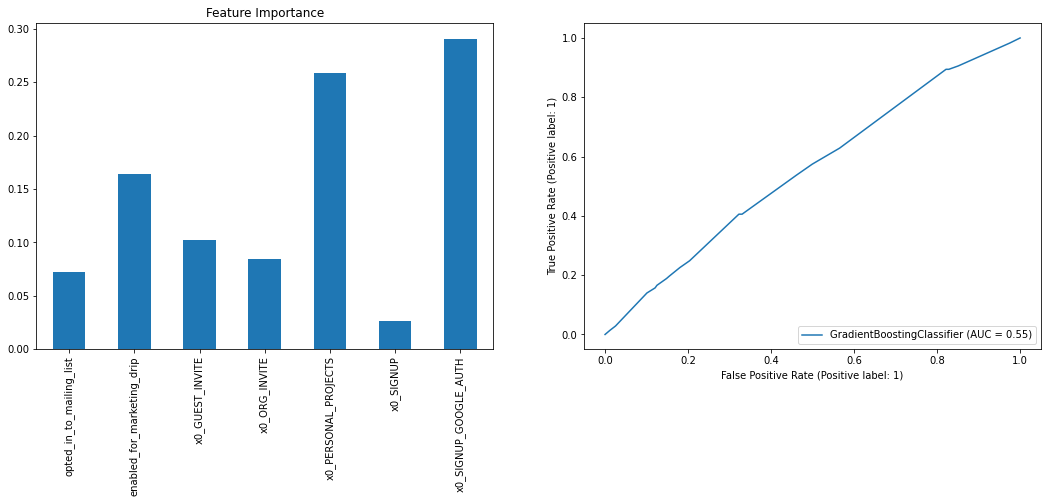

In [211]:
# plot feature importance and AUC-ROC curve
fig, axs = plt.subplots(1,2, figsize=(18,6))
best_est = gs.best_estimator_
feat_importance = pd.DataFrame(best_est.feature_importances_, index=X.columns)
feat_importance.plot(kind="bar", legend=None, ax=axs[0], title="Feature Importance")
plot_roc_curve(best_est, X_test, y_test, ax=axs[1])
plt.show();

In [212]:
y_pred = best_est.predict(X_test)
accuracy_score(y_test, y_pred)

0.9027777777777778

### Conclusions

Even with tuning hyperparameters using GridSearchCV, I was only able to get an ROC_AUC score that is slightly better than the score I got with a dummy classifier that just selects the most frequent class. 

This could be because there are not enough features for the classifier to learn the relationship between the features and the target. It is unlikely that another algorithm would have better performance, as gradient boosting usually outperforms other classification models. 

Therefore, even though our model is 90% accurate, this does not tell us anything about its capacity to predict whether or not a user will adopt the service because the dummy classifier also scored 90% accuracy. 

We do get a picture of the important features, with the **SIGNUP_GOOGL_AUTH** and **PERSONAL_PROJECTS** labels in the **creation_source** feature being the most decisive in determining which users adopt and which ones don't. This matches our observations from EDA. 

However, this conclusion should be taken with a grain of salt, as the model did not learn the relationship between features and target very well. More data is required to get more accurate results. 